In [11]:
import os
import random
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from glob import glob
from PIL import ImageFile
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import seaborn as sns

In [12]:
# seeds
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)
random.seed(seed)

# Suppress PIL warnings
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [13]:
# Constants
ROOT_DIR = "Datasets/corrected_wildfires_dataset"
IMAGE_SIZE = (224, 224)
NUM_CLASSES = 2
EPOCHS = 10
NUM_FOLDS = 10
BATCH_SIZE = 32

In [14]:
# Prepare dataset and labels
image_paths = glob(f"{ROOT_DIR}/*/*.jpg")
class_labels = {"fire": 0, "nofire": 1}

# Filter image paths and extract labels
filtered_image_paths = []
labels = []
for p in image_paths:
    label_name = os.path.basename(os.path.dirname(p))
    if label_name in class_labels:
        filtered_image_paths.append(p)
        labels.append(class_labels[label_name])

# Convert to numpy arrays
image_paths = np.array(filtered_image_paths)
labels = np.array(labels)

# Check class distribution before balancing
unique, counts = np.unique(labels, return_counts=True)
class_counts = dict(zip(unique, counts))
print("Class distribution before balancing:", class_counts)

Class distribution before balancing: {np.int64(0): np.int64(469), np.int64(1): np.int64(990)}


In [15]:
# Balance the classes by undersampling the majority class
min_count = min(class_counts.values())

balanced_image_paths = []
balanced_labels = []

for class_label in np.unique(labels):
    class_indices = np.where(labels == class_label)[0]
    sampled_indices = np.random.choice(class_indices, min_count, replace=False)
    balanced_image_paths.extend(image_paths[sampled_indices])
    balanced_labels.extend([class_label] * min_count)

# Convert to numpy arrays
balanced_image_paths = np.array(balanced_image_paths)
balanced_labels = np.array(balanced_labels)

# Shuffle the balanced dataset
indices = np.arange(len(balanced_image_paths))
np.random.shuffle(indices)
balanced_image_paths = balanced_image_paths[indices]
balanced_labels = balanced_labels[indices]

# Update image_paths and labels to the balanced dataset
image_paths = balanced_image_paths
labels = balanced_labels

# Check class distribution after balancing
unique, counts = np.unique(labels, return_counts=True)
class_counts = dict(zip(unique, counts))
print("Class distribution after balancing:", class_counts)

Class distribution after balancing: {np.int64(0): np.int64(469), np.int64(1): np.int64(469)}


In [16]:
# Split data into training and validation sets
train_paths, val_paths, train_labels, val_labels = train_test_split(
    image_paths, labels, test_size=0.2, stratify=labels, random_state=seed
)

# Create reverse mapping from label indices to class names
rev_class_labels = {v: k for k, v in class_labels.items()}

# Create DataFrames for generators with string labels
train_df = pd.DataFrame({
    'filename': train_paths,
    'class': [rev_class_labels[label] for label in train_labels]
})

val_df = pd.DataFrame({
    'filename': val_paths,
    'class': [rev_class_labels[label] for label in val_labels]
})


In [17]:
# Data augmentation and normalization
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    horizontal_flip=True,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=[0.9, 1.1]
)

val_datagen = ImageDataGenerator(rescale=1./255)

In [18]:
# Define diverse architectures
architectures = [
     {
        'name': 'Arch1',
        'num_conv_layers': 1,
        'num_filters': [32],
        'kernel_sizes': [3],
        'fc_units': 64,
        'dropout_rate': 0.2,
    },
    {
        'name': 'Arch2',
        'num_conv_layers': 2,
        'num_filters': [32, 64],
        'kernel_sizes': [3, 3],
        'fc_units': 128,
        'dropout_rate': 0.3,
    },
     {
        'name': 'Arch3',
        'num_conv_layers': 2,
        'num_filters': [64, 128],
        'kernel_sizes': [5, 5],
        'fc_units': 256,
        'dropout_rate': 0.5,
    },
       {
        'name': 'Arch4',
        'num_conv_layers': 2,
        'num_filters': [64, 64],
        'kernel_sizes': [3, 3],
        'fc_units': 128,
        'dropout_rate': 0.3,
    },
    {
        'name': 'Arch5',
        'num_conv_layers': 3,
        'num_filters': [32, 64, 128],
        'kernel_sizes': [3, 3, 3],
        'fc_units': 128,
        'dropout_rate': 0.3,
    },
   
    {
        'name': 'Arch6',
        'num_conv_layers': 3,
        'num_filters': [64, 128, 256],
        'kernel_sizes': [3, 3, 3],
        'fc_units': 256,
        'dropout_rate': 0.5,
    },
   {
        'name': 'Arch7',
        'num_conv_layers': 3,
        'num_filters': [32, 64, 64],
        'kernel_sizes': [5, 5, 5],
        'fc_units': 128,
        'dropout_rate': 0.4,
    },
   
    {
        'name': 'Arch8',
        'num_conv_layers': 3,
        'num_filters': [64, 128, 256],
        'kernel_sizes': [5, 3, 3],
        'fc_units': 256,
        'dropout_rate': 0.3,
    },
    {
        'name': 'Arch9',
        'num_conv_layers': 4,
        'num_filters': [32, 64, 128, 256],
        'kernel_sizes': [5, 3, 3, 3],
        'fc_units': 128,
        'dropout_rate': 0.5,
    },
     {
        'name': 'Arch10',
        'num_conv_layers': 4,
        'num_filters': [32, 64, 128, 256],
        'kernel_sizes': [3, 3, 3, 3],
        'fc_units': 128,
        'dropout_rate': 0.4,
    },
   
    
]

In [19]:
def create_model(arch):
    model = models.Sequential(name=arch['name'])
    input_shape = (IMAGE_SIZE[0], IMAGE_SIZE[1], 3)
    model.add(layers.InputLayer(shape=input_shape))  # Updated line
    for i in range(arch['num_conv_layers']):
        filters = arch['num_filters'][i]
        kernel_size = arch['kernel_sizes'][i]
        model.add(layers.Conv2D(filters, kernel_size, padding='same', activation='relu'))
        model.add(layers.BatchNormalization())
        model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(arch['fc_units'], activation='relu'))
    model.add(layers.Dropout(arch['dropout_rate']))
    model.add(layers.Dense(1, activation='sigmoid'))
    return model


In [20]:
# Evaluate architectures
results = []
learning_rate = 0.001

print("\nStarting Architecture Evaluation...")
for arch in architectures:
    print(f"\nEvaluating Architecture: {arch['name']}")
    model = create_model(arch)
    model.compile(optimizer=optimizers.Adam(learning_rate=learning_rate),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    # Create generators for this architecture
    train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_df,
        x_col='filename',
        y_col='class',
        target_size=IMAGE_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='binary'
    )
    
    val_generator = val_datagen.flow_from_dataframe(
        dataframe=val_df,
        x_col='filename',
        y_col='class',
        target_size=IMAGE_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='binary',
        shuffle=False
    )
    
    # Early stopping
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    
    # Training
    history = model.fit(
        train_generator,
        epochs=EPOCHS,
        validation_data=val_generator,
        callbacks=[early_stopping],
        verbose=1
    )
    
    # Evaluation
    val_generator.reset()
    preds = model.predict(val_generator)
    y_pred = (preds > 0.5).astype(int).flatten()
    y_true = val_generator.classes
    
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    
    # Compute metrics
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0  # Sensitivity
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0
    roc_auc = roc_auc_score(y_true, preds) if not np.isnan(preds).any() else 0.0
    
    # Print metrics
    print(f"\nMetrics for Architecture {arch['name']}:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"TP: {tp}, FP: {fp}, TN: {tn}, FN: {fn}")
    print(f"Sensitivity (Recall): {recall:.4f}")
    print(f"Specificity: {specificity:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Area Under ROC Curve: {roc_auc:.4f}")
    
    # Store results
    results.append({
        'architecture': arch['name'],
        'model': model,
        'accuracy': accuracy,
        'tp': tp,
        'fp': fp,
        'tn': tn,
        'fn': fn,
        'sensitivity': recall,
        'specificity': specificity,
        'precision': precision,
        'f1_score': f1,
        'roc_auc': roc_auc
    })


Starting Architecture Evaluation...

Evaluating Architecture: Arch1
Found 750 validated image filenames belonging to 2 classes.
Found 188 validated image filenames belonging to 2 classes.


C:\Users\racha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 140s 6s/step - accuracy: 0.6511 - loss: 14.9495 - val_accuracy: 0.7128 - val_loss: 0.6044
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 133s 6s/step - accuracy: 0.7015 - loss: 1.3131 - val_accuracy: 0.5638 - val_loss: 0.6556
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 129s 5s/step - accuracy: 0.7449 - loss: 0.7120 - val_accuracy: 0.5745 - val_loss: 0.6433
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 127s 5s/step - accuracy: 0.7277 - loss: 0.5027 - val_accuracy: 0.5691 - val_loss: 0.6400
6/6 ━━━━━━━━━━━━━━━━━━━━ 22s 3s/step

Metrics for Architecture Arch1:
Accuracy: 0.7128
TP: 72, FP: 32, TN: 62, FN: 22
Sensitivity (Recall): 0.7660
Specificity: 0.6596
Precision: 0.6923
F1 Score: 0.7273
Area Under ROC Curve: 0.7928

Evaluating Architecture: Arch2
Found 750 validated image filenames belonging to 2 classes.
Found 188 validated image filenames belonging to 2 classes.


C:\Users\racha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 147s 6s/step - accuracy: 0.6762 - loss: 16.4108 - val_accuracy: 0.5106 - val_loss: 3.2456
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 138s 6s/step - accuracy: 0.6974 - loss: 5.8046 - val_accuracy: 0.5638 - val_loss: 5.3962
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 136s 6s/step - accuracy: 0.7548 - loss: 3.8261 - val_accuracy: 0.5000 - val_loss: 29.2694
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 135s 6s/step - accuracy: 0.7741 - loss: 2.0029 - val_accuracy: 0.5053 - val_loss: 22.8119
6/6 ━━━━━━━━━━━━━━━━━━━━ 24s 4s/step

Metrics for Architecture Arch2:
Accuracy: 0.5106
TP: 3, FP: 1, TN: 93, FN: 91
Sensitivity (Recall): 0.0319
Specificity: 0.9894
Precision: 0.7500
F1 Score: 0.0612
Area Under ROC Curve: 0.5189

Evaluating Architecture: Arch3
Found 750 validated image filenames belonging to 2 classes.
Found 188 validated image filenames belonging to 2 classes.


C:\Users\racha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 185s 8s/step - accuracy: 0.6812 - loss: 53.7214 - val_accuracy: 0.5106 - val_loss: 18.4038
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 174s 7s/step - accuracy: 0.7013 - loss: 25.9946 - val_accuracy: 0.6011 - val_loss: 21.6614
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 173s 7s/step - accuracy: 0.7471 - loss: 16.6651 - val_accuracy: 0.5745 - val_loss: 21.0832
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 173s 7s/step - accuracy: 0.7320 - loss: 14.8575 - val_accuracy: 0.5851 - val_loss: 37.3192
6/6 ━━━━━━━━━━━━━━━━━━━━ 23s 4s/step

Metrics for Architecture Arch3:
Accuracy: 0.5106
TP: 2, FP: 0, TN: 94, FN: 92
Sensitivity (Recall): 0.0213
Specificity: 1.0000
Precision: 1.0000
F1 Score: 0.0417
Area Under ROC Curve: 0.7372

Evaluating Architecture: Arch4
Found 750 validated image filenames belonging to 2 classes.
Found 188 validated image filenames belonging to 2 classes.


C:\Users\racha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 157s 7s/step - accuracy: 0.6303 - loss: 19.3833 - val_accuracy: 0.5904 - val_loss: 1.9926
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 147s 6s/step - accuracy: 0.7583 - loss: 7.2988 - val_accuracy: 0.6702 - val_loss: 4.3894
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 147s 6s/step - accuracy: 0.7345 - loss: 3.4769 - val_accuracy: 0.5691 - val_loss: 11.1647
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 147s 6s/step - accuracy: 0.7187 - loss: 1.0153 - val_accuracy: 0.6543 - val_loss: 8.4943
6/6 ━━━━━━━━━━━━━━━━━━━━ 22s 3s/step

Metrics for Architecture Arch4:
Accuracy: 0.5904
TP: 20, FP: 3, TN: 91, FN: 74
Sensitivity (Recall): 0.2128
Specificity: 0.9681
Precision: 0.8696
F1 Score: 0.3419
Area Under ROC Curve: 0.7527

Evaluating Architecture: Arch5
Found 750 validated image filenames belonging to 2 classes.
Found 188 validated image filenames belonging to 2 classes.


C:\Users\racha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 144s 6s/step - accuracy: 0.6238 - loss: 11.3507 - val_accuracy: 0.5000 - val_loss: 19.0638
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 134s 6s/step - accuracy: 0.7207 - loss: 1.5028 - val_accuracy: 0.5000 - val_loss: 25.6394
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 134s 6s/step - accuracy: 0.7269 - loss: 0.6116 - val_accuracy: 0.5000 - val_loss: 34.8331
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 134s 6s/step - accuracy: 0.7671 - loss: 0.5771 - val_accuracy: 0.6649 - val_loss: 5.0057
Epoch 5/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 134s 6s/step - accuracy: 0.7604 - loss: 0.4583 - val_accuracy: 0.6330 - val_loss: 4.7984
Epoch 6/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 134s 6s/step - accuracy: 0.7880 - loss: 0.4305 - val_accuracy: 0.6596 - val_loss: 4.2625
Epoch 7/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 134s 6s/step - accuracy: 0.7952 - loss: 0.4640 - val_accuracy: 0.5053 - val_loss: 29.3376
Epoch 8/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 135s 6s/step - accuracy: 0.8172 - loss: 0.4147 - val_accuracy: 0.505

C:\Users\racha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 182s 8s/step - accuracy: 0.6264 - loss: 28.7608 - val_accuracy: 0.4947 - val_loss: 36.7429
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 173s 7s/step - accuracy: 0.7009 - loss: 20.3461 - val_accuracy: 0.5532 - val_loss: 15.1936
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 172s 7s/step - accuracy: 0.7507 - loss: 8.8589 - val_accuracy: 0.6755 - val_loss: 5.5496
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 171s 7s/step - accuracy: 0.7585 - loss: 9.0979 - val_accuracy: 0.5106 - val_loss: 12.1666
Epoch 5/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 171s 7s/step - accuracy: 0.7594 - loss: 5.7169 - val_accuracy: 0.5000 - val_loss: 35.4400
Epoch 6/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 171s 7s/step - accuracy: 0.7451 - loss: 4.7917 - val_accuracy: 0.5000 - val_loss: 33.4526
6/6 ━━━━━━━━━━━━━━━━━━━━ 23s 4s/step

Metrics for Architecture Arch6:
Accuracy: 0.6755
TP: 51, FP: 18, TN: 76, FN: 43
Sensitivity (Recall): 0.5426
Specificity: 0.8085
Precision: 0.7391
F1 Score: 0.6258
Area Under ROC Curve: 0.7664


C:\Users\racha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 143s 6s/step - accuracy: 0.6362 - loss: 7.6606 - val_accuracy: 0.3351 - val_loss: 5.6105
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 133s 6s/step - accuracy: 0.7479 - loss: 2.2594 - val_accuracy: 0.5000 - val_loss: 13.1960
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 132s 6s/step - accuracy: 0.6661 - loss: 2.2514 - val_accuracy: 0.5000 - val_loss: 24.6468
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 132s 6s/step - accuracy: 0.7535 - loss: 1.1326 - val_accuracy: 0.5000 - val_loss: 26.0734
6/6 ━━━━━━━━━━━━━━━━━━━━ 22s 3s/step

Metrics for Architecture Arch7:
Accuracy: 0.3351
TP: 37, FP: 68, TN: 26, FN: 57
Sensitivity (Recall): 0.3936
Specificity: 0.2766
Precision: 0.3524
F1 Score: 0.3719
Area Under ROC Curve: 0.3165

Evaluating Architecture: Arch8
Found 750 validated image filenames belonging to 2 classes.
Found 188 validated image filenames belonging to 2 classes.


C:\Users\racha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 183s 7s/step - accuracy: 0.6518 - loss: 24.6600 - val_accuracy: 0.4149 - val_loss: 35.3861
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 172s 7s/step - accuracy: 0.6934 - loss: 4.5634 - val_accuracy: 0.5532 - val_loss: 34.6285
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 173s 7s/step - accuracy: 0.7373 - loss: 4.0356 - val_accuracy: 0.5000 - val_loss: 35.0157
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 173s 7s/step - accuracy: 0.7305 - loss: 1.0065 - val_accuracy: 0.5053 - val_loss: 21.9740
Epoch 5/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 171s 7s/step - accuracy: 0.7455 - loss: 0.7819 - val_accuracy: 0.6223 - val_loss: 23.8315
Epoch 6/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 171s 7s/step - accuracy: 0.7565 - loss: 0.5823 - val_accuracy: 0.6755 - val_loss: 14.1551
Epoch 7/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 172s 7s/step - accuracy: 0.7316 - loss: 0.5524 - val_accuracy: 0.6809 - val_loss: 12.1125
Epoch 8/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 172s 7s/step - accuracy: 0.7465 - loss: 0.4972 - val_accuracy: 0.

C:\Users\racha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 145s 6s/step - accuracy: 0.6034 - loss: 6.3053 - val_accuracy: 0.5000 - val_loss: 2.9376
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 134s 6s/step - accuracy: 0.7149 - loss: 2.9904 - val_accuracy: 0.4149 - val_loss: 2.8654
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 134s 6s/step - accuracy: 0.7325 - loss: 1.5415 - val_accuracy: 0.5053 - val_loss: 2.5465
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 134s 6s/step - accuracy: 0.7469 - loss: 1.1887 - val_accuracy: 0.4628 - val_loss: 2.3751
Epoch 5/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 135s 6s/step - accuracy: 0.7298 - loss: 1.0637 - val_accuracy: 0.5000 - val_loss: 3.3727
Epoch 6/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 134s 6s/step - accuracy: 0.7260 - loss: 0.8863 - val_accuracy: 0.5106 - val_loss: 1.4569
Epoch 7/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 133s 6s/step - accuracy: 0.7382 - loss: 0.9228 - val_accuracy: 0.6011 - val_loss: 1.8039
Epoch 8/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 134s 6s/step - accuracy: 0.7495 - loss: 0.9524 - val_accuracy: 0.6383 - v

C:\Users\racha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 144s 6s/step - accuracy: 0.6556 - loss: 6.3703 - val_accuracy: 0.5000 - val_loss: 1.9414
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 135s 6s/step - accuracy: 0.7390 - loss: 1.5691 - val_accuracy: 0.5000 - val_loss: 2.8488
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 135s 6s/step - accuracy: 0.7662 - loss: 1.4612 - val_accuracy: 0.5000 - val_loss: 1.7080
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 134s 6s/step - accuracy: 0.7314 - loss: 0.8660 - val_accuracy: 0.5000 - val_loss: 4.7259
Epoch 5/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 135s 6s/step - accuracy: 0.8098 - loss: 0.5669 - val_accuracy: 0.5000 - val_loss: 2.9410
Epoch 6/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 134s 6s/step - accuracy: 0.7642 - loss: 0.5902 - val_accuracy: 0.5106 - val_loss: 1.7700
6/6 ━━━━━━━━━━━━━━━━━━━━ 22s 3s/step

Metrics for Architecture Arch10:
Accuracy: 0.5000
TP: 0, FP: 0, TN: 94, FN: 94
Sensitivity (Recall): 0.0000
Specificity: 1.0000
Precision: 0.0000
F1 Score: 0.0000
Area Under ROC Curve: 0.5435


In [21]:
# Create a DataFrame with the results
results_df = pd.DataFrame(results)
print("\nArchitectures Evaluation Results:")
print(results_df[['architecture', 'accuracy', 'precision', 'sensitivity', 'specificity', 'f1_score', 'roc_auc']])

# Find the best architecture based on accuracy
best_architecture_name = results_df.sort_values(by='accuracy', ascending=False).iloc[0]['architecture']
best_model_info = results_df[results_df['architecture'] == best_architecture_name].iloc[0]
best_model = best_model_info['model']
best_architecture = next(arch for arch in architectures if arch['name'] == best_architecture_name)

print(f"\nBest Architecture: {best_architecture_name}")


Architectures Evaluation Results:
  architecture  accuracy  precision  sensitivity  specificity  f1_score  \
0        Arch1  0.712766   0.692308     0.765957     0.659574  0.727273   
1        Arch2  0.510638   0.750000     0.031915     0.989362  0.061224   
2        Arch3  0.510638   1.000000     0.021277     1.000000  0.041667   
3        Arch4  0.590426   0.869565     0.212766     0.968085  0.341880   
4        Arch5  0.659574   0.659574     0.659574     0.659574  0.659574   
5        Arch6  0.675532   0.739130     0.542553     0.808511  0.625767   
6        Arch7  0.335106   0.352381     0.393617     0.276596  0.371859   
7        Arch8  0.675532   0.746269     0.531915     0.819149  0.621118   
8        Arch9  0.632979   0.903226     0.297872     0.968085  0.448000   
9       Arch10  0.500000   0.000000     0.000000     1.000000  0.000000   

    roc_auc  
0  0.792780  
1  0.518900  
2  0.737211  
3  0.752716  
4  0.705353  
5  0.766410  
6  0.316546  
7  0.785197  
8  0.749660  

C:\Users\racha\AppData\Local\Temp\ipykernel_19204\322885006.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results_df, x='architecture', y='accuracy', palette='viridis')


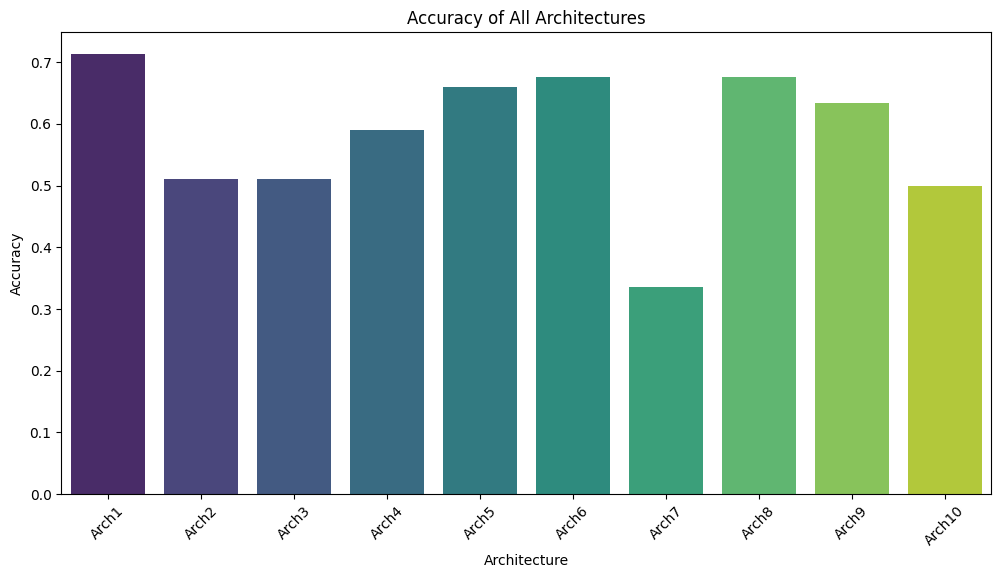

C:\Users\racha\AppData\Local\Temp\ipykernel_19204\322885006.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results_df, x='architecture', y='roc_auc', palette='coolwarm')


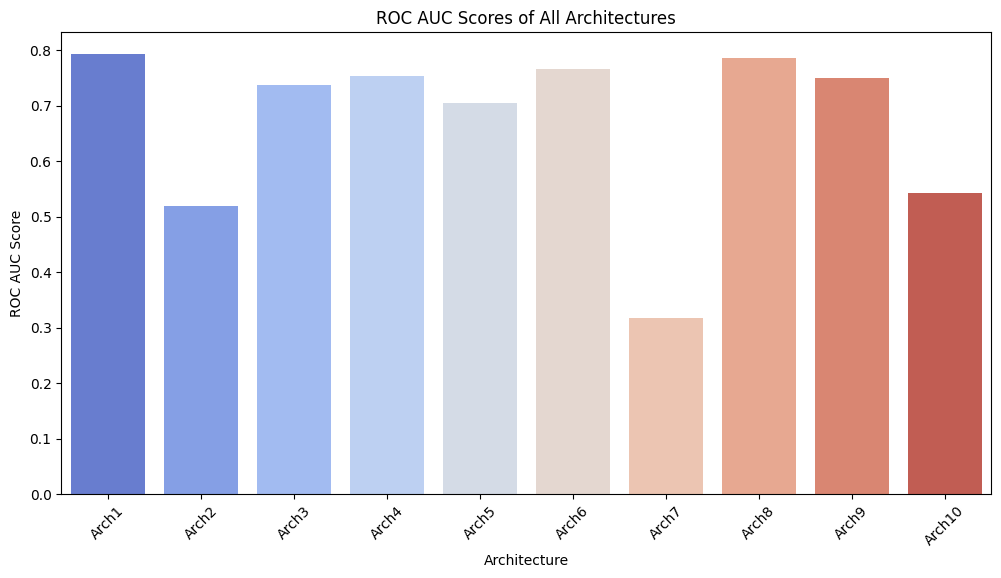

In [38]:
# Training results for all architectures
plt.figure(figsize=(12, 6))
plt.title('Accuracy of All Architectures')
sns.barplot(data=results_df, x='architecture', y='accuracy', palette='viridis')
plt.xlabel('Architecture')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(12, 6))
plt.title('ROC AUC Scores of All Architectures')
sns.barplot(data=results_df, x='architecture', y='roc_auc', palette='coolwarm')
plt.xlabel('Architecture')
plt.ylabel('ROC AUC Score')
plt.xticks(rotation=45)
plt.show()

In [22]:
# Stratified K-Fold Cross Validation on Best Architecture (We use stratified to maintain class distribution)
print(f"\nConducting K-Fold Validation on Best Architecture: {best_architecture_name}")

kfold = StratifiedKFold(n_splits=NUM_FOLDS, shuffle=True, random_state=seed)
fold_metrics = []

for fold, (train_idx, val_idx) in enumerate(kfold.split(image_paths, labels)):
    print(f"\nFold {fold+1}/{NUM_FOLDS}")
    train_paths_fold, val_paths_fold = image_paths[train_idx], image_paths[val_idx]
    train_labels_fold, val_labels_fold = labels[train_idx], labels[val_idx]
    
    # Create DataFrames for generators with string labels
    train_df_fold = pd.DataFrame({
        'filename': train_paths_fold,
        'class': [rev_class_labels[label] for label in train_labels_fold]
    })

    val_df_fold = pd.DataFrame({
        'filename': val_paths_fold,
        'class': [rev_class_labels[label] for label in val_labels_fold]
    })
    
    # Create generators
    train_generator_fold = train_datagen.flow_from_dataframe(
        dataframe=train_df_fold,
        x_col='filename',
        y_col='class',
        target_size=IMAGE_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='binary'
    )
    
    val_generator_fold = val_datagen.flow_from_dataframe(
        dataframe=val_df_fold,
        x_col='filename',
        y_col='class',
        target_size=IMAGE_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='binary',
        shuffle=False
    )
    
    # Create model
    model = create_model(best_architecture)
    model.compile(optimizer=optimizers.Adam(learning_rate=learning_rate),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    # Implement early stopping
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    
    # Training
    history = model.fit(
        train_generator_fold,
        epochs=EPOCHS,
        validation_data=val_generator_fold,
        callbacks=[early_stopping],
        verbose=1
    )
    
    # Evaluation
    val_generator_fold.reset()
    preds = model.predict(val_generator_fold)
    y_pred = (preds > 0.5).astype(int).flatten()
    y_true = val_generator_fold.classes
    
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    
    # Compute metrics
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0  # Sensitivity
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0
    roc_auc = roc_auc_score(y_true, preds) if not np.isnan(preds).any() else 0.0
    
    # Print metrics
    print(f"\nMetrics for Fold {fold+1}:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"TP: {tp}, FP: {fp}, TN: {tn}, FN: {fn}")
    print(f"Sensitivity (Recall): {recall:.4f}")
    print(f"Specificity: {specificity:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Area Under ROC Curve: {roc_auc:.4f}")
    
    # Store metrics
    fold_metrics.append({
        'fold': fold + 1,
        'accuracy': accuracy,
        'tp': tp,
        'fp': fp,
        'tn': tn,
        'fn': fn,
        'sensitivity': recall,
        'specificity': specificity,
        'precision': precision,
        'f1_score': f1,
        'roc_auc': roc_auc
    })

# Average metrics over folds
kfold_results_df = pd.DataFrame(fold_metrics)
avg_metrics = kfold_results_df.mean()
print("\nK-Fold Cross-Validation Results:")
print(kfold_results_df[['fold', 'accuracy', 'precision', 'sensitivity', 'specificity', 'f1_score', 'roc_auc']])
print("\nAverage Metrics over all folds:")
print(avg_metrics[['accuracy', 'precision', 'sensitivity', 'specificity', 'f1_score', 'roc_auc']])



Conducting K-Fold Validation on Best Architecture: Arch1

Fold 1/10
Found 844 validated image filenames belonging to 2 classes.
Found 94 validated image filenames belonging to 2 classes.


C:\Users\racha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 138s 5s/step - accuracy: 0.6106 - loss: 32.9996 - val_accuracy: 0.5532 - val_loss: 1.4116
Epoch 2/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 128s 5s/step - accuracy: 0.6681 - loss: 1.6951 - val_accuracy: 0.6596 - val_loss: 0.5567
Epoch 3/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 129s 5s/step - accuracy: 0.7156 - loss: 1.3365 - val_accuracy: 0.5213 - val_loss: 1.0557
Epoch 4/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 128s 5s/step - accuracy: 0.6241 - loss: 0.9179 - val_accuracy: 0.5426 - val_loss: 0.6282
Epoch 5/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 128s 5s/step - accuracy: 0.7061 - loss: 0.5600 - val_accuracy: 0.6383 - val_loss: 0.6138
3/3 ━━━━━━━━━━━━━━━━━━━━ 13s 4s/step

Metrics for Fold 1:
Accuracy: 0.6596
TP: 15, FP: 0, TN: 47, FN: 32
Sensitivity (Recall): 0.3191
Specificity: 1.0000
Precision: 1.0000
F1 Score: 0.4839
Area Under ROC Curve: 0.8443

Fold 2/10
Found 844 validated image filenames belonging to 2 classes.
Found 94 validated image filenames belonging to 2 classes.


C:\Users\racha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 137s 5s/step - accuracy: 0.6377 - loss: 25.4134 - val_accuracy: 0.5213 - val_loss: 2.1820
Epoch 2/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 129s 5s/step - accuracy: 0.7392 - loss: 3.3375 - val_accuracy: 0.4681 - val_loss: 0.7672
Epoch 3/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 129s 5s/step - accuracy: 0.6611 - loss: 1.2805 - val_accuracy: 0.5638 - val_loss: 0.6315
Epoch 4/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 129s 5s/step - accuracy: 0.6908 - loss: 0.8723 - val_accuracy: 0.5745 - val_loss: 0.6600
Epoch 5/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 129s 5s/step - accuracy: 0.7589 - loss: 0.5212 - val_accuracy: 0.7447 - val_loss: 0.6341
Epoch 6/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 129s 5s/step - accuracy: 0.7820 - loss: 0.5143 - val_accuracy: 0.7340 - val_loss: 0.6239
Epoch 7/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 129s 5s/step - accuracy: 0.7575 - loss: 0.4451 - val_accuracy: 0.7447 - val_loss: 0.6077
Epoch 8/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 129s 5s/step - accuracy: 0.7969 - loss: 0.4433 - val_accuracy: 0.7021 - 

C:\Users\racha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 135s 5s/step - accuracy: 0.6356 - loss: 25.9740 - val_accuracy: 0.5426 - val_loss: 2.5635
Epoch 2/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 128s 5s/step - accuracy: 0.7173 - loss: 6.4010 - val_accuracy: 0.6277 - val_loss: 0.5749
Epoch 3/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 128s 5s/step - accuracy: 0.7058 - loss: 1.3820 - val_accuracy: 0.5957 - val_loss: 0.6811
Epoch 4/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 129s 5s/step - accuracy: 0.7185 - loss: 0.7509 - val_accuracy: 0.5532 - val_loss: 0.6821
Epoch 5/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 129s 5s/step - accuracy: 0.7334 - loss: 0.6520 - val_accuracy: 0.5319 - val_loss: 0.6546
3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 3s/step

Metrics for Fold 3:
Accuracy: 0.6277
TP: 16, FP: 4, TN: 43, FN: 31
Sensitivity (Recall): 0.3404
Specificity: 0.9149
Precision: 0.8000
F1 Score: 0.4776
Area Under ROC Curve: 0.7904

Fold 4/10
Found 844 validated image filenames belonging to 2 classes.
Found 94 validated image filenames belonging to 2 classes.


C:\Users\racha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 138s 5s/step - accuracy: 0.6400 - loss: 29.0639 - val_accuracy: 0.7234 - val_loss: 0.6201
Epoch 2/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 130s 5s/step - accuracy: 0.6728 - loss: 2.6507 - val_accuracy: 0.7447 - val_loss: 0.6098
Epoch 3/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 129s 5s/step - accuracy: 0.7179 - loss: 0.6944 - val_accuracy: 0.7553 - val_loss: 0.6290
Epoch 4/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 129s 5s/step - accuracy: 0.7167 - loss: 0.5090 - val_accuracy: 0.8298 - val_loss: 0.5972
Epoch 5/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 129s 5s/step - accuracy: 0.7324 - loss: 0.4652 - val_accuracy: 0.7979 - val_loss: 0.5784
Epoch 6/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 129s 5s/step - accuracy: 0.7643 - loss: 0.4451 - val_accuracy: 0.8298 - val_loss: 0.5806
Epoch 7/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 129s 5s/step - accuracy: 0.8158 - loss: 0.4520 - val_accuracy: 0.8191 - val_loss: 0.5505
Epoch 8/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 129s 5s/step - accuracy: 0.8039 - loss: 0.3888 - val_accuracy: 0.8191 - 

C:\Users\racha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 139s 5s/step - accuracy: 0.6223 - loss: 16.0521 - val_accuracy: 0.5638 - val_loss: 4.9609
Epoch 2/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 130s 5s/step - accuracy: 0.7307 - loss: 4.1210 - val_accuracy: 0.5426 - val_loss: 0.8033
Epoch 3/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 130s 5s/step - accuracy: 0.7443 - loss: 1.2760 - val_accuracy: 0.5638 - val_loss: 0.6684
Epoch 4/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 130s 5s/step - accuracy: 0.7768 - loss: 0.5975 - val_accuracy: 0.5532 - val_loss: 0.6779
Epoch 5/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 130s 5s/step - accuracy: 0.7700 - loss: 0.7882 - val_accuracy: 0.6170 - val_loss: 0.6304
Epoch 6/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 130s 5s/step - accuracy: 0.8352 - loss: 0.4979 - val_accuracy: 0.6809 - val_loss: 0.5925
Epoch 7/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 130s 5s/step - accuracy: 0.8162 - loss: 0.3801 - val_accuracy: 0.7340 - val_loss: 0.5781
Epoch 8/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 130s 5s/step - accuracy: 0.8089 - loss: 0.3738 - val_accuracy: 0.7553 - 

C:\Users\racha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 138s 5s/step - accuracy: 0.6321 - loss: 14.8992 - val_accuracy: 0.6064 - val_loss: 2.5805
Epoch 2/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 129s 5s/step - accuracy: 0.7142 - loss: 2.7409 - val_accuracy: 0.5319 - val_loss: 0.8266
Epoch 3/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 129s 5s/step - accuracy: 0.7021 - loss: 2.4123 - val_accuracy: 0.5745 - val_loss: 0.7324
Epoch 4/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 130s 5s/step - accuracy: 0.7857 - loss: 1.0795 - val_accuracy: 0.5745 - val_loss: 0.6489
Epoch 5/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 130s 5s/step - accuracy: 0.7746 - loss: 0.5314 - val_accuracy: 0.6170 - val_loss: 0.6227
Epoch 6/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 130s 5s/step - accuracy: 0.7594 - loss: 0.5702 - val_accuracy: 0.6915 - val_loss: 0.5778
Epoch 7/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 130s 5s/step - accuracy: 0.7860 - loss: 0.4762 - val_accuracy: 0.6277 - val_loss: 0.6126
Epoch 8/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 129s 5s/step - accuracy: 0.7462 - loss: 0.4161 - val_accuracy: 0.7021 - 

C:\Users\racha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 137s 5s/step - accuracy: 0.6526 - loss: 19.1200 - val_accuracy: 0.5319 - val_loss: 3.2646
Epoch 2/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 130s 5s/step - accuracy: 0.6927 - loss: 3.8528 - val_accuracy: 0.6489 - val_loss: 1.0180
Epoch 3/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 130s 5s/step - accuracy: 0.7670 - loss: 1.4312 - val_accuracy: 0.6383 - val_loss: 0.7017
Epoch 4/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 131s 5s/step - accuracy: 0.7581 - loss: 0.7223 - val_accuracy: 0.5745 - val_loss: 0.6249
Epoch 5/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 131s 5s/step - accuracy: 0.7529 - loss: 0.4976 - val_accuracy: 0.6170 - val_loss: 0.6230
Epoch 6/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 131s 5s/step - accuracy: 0.8091 - loss: 0.4355 - val_accuracy: 0.5851 - val_loss: 0.6925
Epoch 7/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 131s 5s/step - accuracy: 0.7876 - loss: 0.4506 - val_accuracy: 0.7128 - val_loss: 0.5724
Epoch 8/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 131s 5s/step - accuracy: 0.7839 - loss: 0.4346 - val_accuracy: 0.7340 - 

C:\Users\racha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 137s 5s/step - accuracy: 0.6542 - loss: 24.0778 - val_accuracy: 0.5957 - val_loss: 1.9018
Epoch 2/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 131s 5s/step - accuracy: 0.7287 - loss: 2.8343 - val_accuracy: 0.5213 - val_loss: 0.7002
Epoch 3/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 130s 5s/step - accuracy: 0.7379 - loss: 2.0299 - val_accuracy: 0.5213 - val_loss: 0.6384
Epoch 4/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 130s 5s/step - accuracy: 0.7288 - loss: 0.6869 - val_accuracy: 0.5745 - val_loss: 0.6388
Epoch 5/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 131s 5s/step - accuracy: 0.7393 - loss: 0.5451 - val_accuracy: 0.6383 - val_loss: 0.5786
Epoch 6/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 130s 5s/step - accuracy: 0.7655 - loss: 0.4623 - val_accuracy: 0.5957 - val_loss: 0.6249
Epoch 7/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 130s 5s/step - accuracy: 0.7739 - loss: 0.4370 - val_accuracy: 0.6596 - val_loss: 0.5764
Epoch 8/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 131s 5s/step - accuracy: 0.7801 - loss: 0.4104 - val_accuracy: 0.6277 - 

C:\Users\racha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 141s 5s/step - accuracy: 0.5973 - loss: 24.4686 - val_accuracy: 0.6237 - val_loss: 0.9722
Epoch 2/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 132s 5s/step - accuracy: 0.7008 - loss: 1.7198 - val_accuracy: 0.5591 - val_loss: 1.2261
Epoch 3/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 131s 5s/step - accuracy: 0.6859 - loss: 1.9380 - val_accuracy: 0.5269 - val_loss: 1.0654
Epoch 4/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 130s 5s/step - accuracy: 0.6706 - loss: 0.8429 - val_accuracy: 0.5806 - val_loss: 0.7470
Epoch 5/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 131s 5s/step - accuracy: 0.7046 - loss: 0.9432 - val_accuracy: 0.5699 - val_loss: 0.7860
Epoch 6/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 131s 5s/step - accuracy: 0.7395 - loss: 0.6202 - val_accuracy: 0.5806 - val_loss: 0.7356
Epoch 7/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 131s 5s/step - accuracy: 0.6784 - loss: 0.6378 - val_accuracy: 0.6774 - val_loss: 0.6667
Epoch 8/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 131s 5s/step - accuracy: 0.6930 - loss: 0.7410 - val_accuracy: 0.6774 - 

C:\Users\racha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 139s 5s/step - accuracy: 0.6581 - loss: 23.4914 - val_accuracy: 0.7527 - val_loss: 0.6993
Epoch 2/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 131s 5s/step - accuracy: 0.7101 - loss: 4.4526 - val_accuracy: 0.7957 - val_loss: 0.6634
Epoch 3/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 130s 5s/step - accuracy: 0.7041 - loss: 1.3379 - val_accuracy: 0.4731 - val_loss: 1.3736
Epoch 4/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 130s 5s/step - accuracy: 0.7703 - loss: 0.7388 - val_accuracy: 0.7742 - val_loss: 0.4971
Epoch 5/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 130s 5s/step - accuracy: 0.7648 - loss: 0.6169 - val_accuracy: 0.6989 - val_loss: 0.5663
Epoch 6/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 130s 5s/step - accuracy: 0.7500 - loss: 0.6143 - val_accuracy: 0.6989 - val_loss: 0.5312
Epoch 7/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 131s 5s/step - accuracy: 0.7596 - loss: 0.4806 - val_accuracy: 0.7097 - val_loss: 0.5230
3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 3s/step

Metrics for Fold 10:
Accuracy: 0.7742
TP: 27, FP: 2, TN: 45, FN: 19
Sens

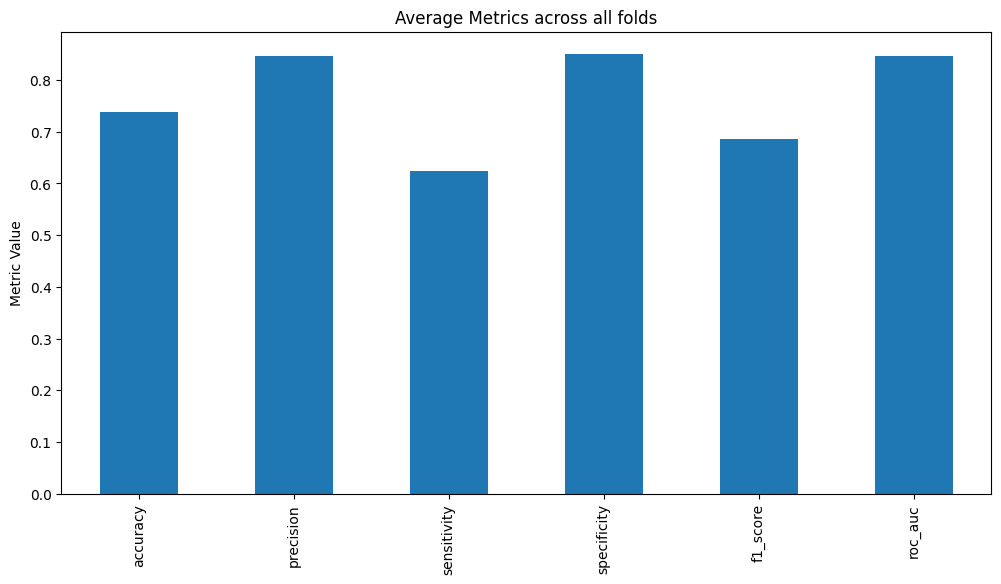

In [40]:
plt.figure(figsize=(12, 6))
kfold_results_df[['accuracy', 'precision', 'sensitivity', 'specificity', 'f1_score', 'roc_auc']].mean().plot(kind='bar')
plt.title('Average Metrics across all folds')
plt.ylabel('Metric Value')
plt.show()

In [23]:
# Hyperparameter tuning on the best architecture
print("\nPerforming Hyperparameter Tuning on the Best Architecture")

# Define hyperparameters for tuning
learning_rates = [0.0001, 0.001, 0.01]
dropout_rates = [0.3, 0.5]
batch_sizes = [16, 32, 64]

tuning_results = []

from itertools import product

for lr, dr, bs in product(learning_rates, dropout_rates, batch_sizes):
    print(f"\nEvaluating Hyperparameters: LR={lr}, Dropout={dr}, Batch Size={bs}")
    arch = best_architecture.copy()
    arch['dropout_rate'] = dr
    
    # Adjust batch size and create generators
    train_generator_tune = train_datagen.flow_from_dataframe(
        dataframe=train_df,
        x_col='filename',
        y_col='class',
        target_size=IMAGE_SIZE,
        batch_size=bs,
        class_mode='binary'
    )

    val_generator_tune = val_datagen.flow_from_dataframe(
        dataframe=val_df,
        x_col='filename',
        y_col='class',
        target_size=IMAGE_SIZE,
        batch_size=bs,
        class_mode='binary',
        shuffle=False
    )
    
    # Create model
    model = create_model(arch)
    model.compile(optimizer=optimizers.Adam(learning_rate=lr),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    # Early stopping
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    
    # Training
    history = model.fit(
        train_generator_tune,
        epochs=EPOCHS,
        validation_data=val_generator_tune,
        callbacks=[early_stopping],
        verbose=1
    )
    
    # Evaluation
    val_generator_tune.reset()
    preds = model.predict(val_generator_tune)
    y_pred = (preds > 0.5).astype(int).flatten()
    y_true = val_generator_tune.classes
    
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    
    # Compute metrics
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0  # Sensitivity
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0
    roc_auc = roc_auc_score(y_true, preds) if not np.isnan(preds).any() else 0.0
    
    # Print metrics
    print(f"\nMetrics for Hyperparameters LR={lr}, Dropout={dr}, Batch Size={bs}:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"TP: {tp}, FP: {fp}, TN: {tn}, FN: {fn}")
    print(f"Sensitivity (Recall): {recall:.4f}")
    print(f"Specificity: {specificity:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Area Under ROC Curve: {roc_auc:.4f}")
    
    # Store results
    tuning_results.append({
        'learning_rate': lr,
        'dropout_rate': dr,
        'batch_size': bs,
        'accuracy': accuracy,
        'tp': tp,
        'fp': fp,
        'tn': tn,
        'fn': fn,
        'sensitivity': recall,
        'specificity': specificity,
        'precision': precision,
        'f1_score': f1,
        'roc_auc': roc_auc
    })

# Create a DataFrame with the tuning results
tuning_results_df = pd.DataFrame(tuning_results)
print("\nHyperparameter Tuning Results:")
print(tuning_results_df[['learning_rate', 'dropout_rate', 'batch_size', 'accuracy', 'precision', 'sensitivity', 'specificity', 'f1_score', 'roc_auc']])




Performing Hyperparameter Tuning on the Best Architecture

Evaluating Hyperparameters: LR=0.0001, Dropout=0.3, Batch Size=16
Found 750 validated image filenames belonging to 2 classes.
Found 188 validated image filenames belonging to 2 classes.


C:\Users\racha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 138s 3s/step - accuracy: 0.6600 - loss: 3.1767 - val_accuracy: 0.5000 - val_loss: 1.4856
Epoch 2/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 132s 3s/step - accuracy: 0.7239 - loss: 2.0022 - val_accuracy: 0.6862 - val_loss: 0.5290
Epoch 3/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 132s 3s/step - accuracy: 0.7494 - loss: 1.1940 - val_accuracy: 0.6649 - val_loss: 0.6197
Epoch 4/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 132s 3s/step - accuracy: 0.7000 - loss: 1.1701 - val_accuracy: 0.6117 - val_loss: 0.8774
Epoch 5/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 132s 3s/step - accuracy: 0.7763 - loss: 0.8982 - val_accuracy: 0.7181 - val_loss: 0.5640
12/12 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step

Metrics for Hyperparameters LR=0.0001, Dropout=0.3, Batch Size=16:
Accuracy: 0.6862
TP: 53, FP: 18, TN: 76, FN: 41
Sensitivity (Recall): 0.5638
Specificity: 0.8085
Precision: 0.7465
F1 Score: 0.6424
Area Under ROC Curve: 0.8068

Evaluating Hyperparameters: LR=0.0001, Dropout=0.3, Batch Size=32
Found 750 validated image file

C:\Users\racha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 138s 6s/step - accuracy: 0.6347 - loss: 2.4740 - val_accuracy: 0.6011 - val_loss: 0.6815
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 129s 5s/step - accuracy: 0.7780 - loss: 0.7484 - val_accuracy: 0.6809 - val_loss: 0.6003
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 129s 5s/step - accuracy: 0.7718 - loss: 0.8256 - val_accuracy: 0.7287 - val_loss: 0.5895
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 129s 5s/step - accuracy: 0.7956 - loss: 0.5395 - val_accuracy: 0.6968 - val_loss: 0.5949
Epoch 5/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 129s 5s/step - accuracy: 0.8043 - loss: 0.5300 - val_accuracy: 0.6755 - val_loss: 0.5764
Epoch 6/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 129s 5s/step - accuracy: 0.8011 - loss: 0.4236 - val_accuracy: 0.6223 - val_loss: 0.5560
Epoch 7/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 129s 5s/step - accuracy: 0.7832 - loss: 0.4860 - val_accuracy: 0.7234 - val_loss: 0.5422
Epoch 8/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 129s 5s/step - accuracy: 0.8172 - loss: 0.4339 - val_accuracy: 0.6755 - v

C:\Users\racha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 144s 12s/step - accuracy: 0.5855 - loss: 4.6701 - val_accuracy: 0.6436 - val_loss: 0.6123
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 128s 11s/step - accuracy: 0.7153 - loss: 3.5522 - val_accuracy: 0.5904 - val_loss: 0.6707
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 127s 11s/step - accuracy: 0.7195 - loss: 1.2898 - val_accuracy: 0.7074 - val_loss: 0.5388
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 127s 11s/step - accuracy: 0.7125 - loss: 0.8746 - val_accuracy: 0.6064 - val_loss: 0.6597
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 127s 11s/step - accuracy: 0.7060 - loss: 0.9050 - val_accuracy: 0.6543 - val_loss: 0.5822
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 127s 11s/step - accuracy: 0.7855 - loss: 0.8004 - val_accuracy: 0.7181 - val_loss: 0.5462
3/3 ━━━━━━━━━━━━━━━━━━━━ 21s 7s/step

Metrics for Hyperparameters LR=0.0001, Dropout=0.3, Batch Size=64:
Accuracy: 0.7074
TP: 46, FP: 7, TN: 87, FN: 48
Sensitivity (Recall): 0.4894
Specificity: 0.9255
Precision: 0.8679
F1 Score: 0.6

C:\Users\racha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 139s 3s/step - accuracy: 0.6122 - loss: 4.2646 - val_accuracy: 0.6862 - val_loss: 0.5507
Epoch 2/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 133s 3s/step - accuracy: 0.7201 - loss: 1.7471 - val_accuracy: 0.6809 - val_loss: 0.6405
Epoch 3/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 132s 3s/step - accuracy: 0.7594 - loss: 0.9257 - val_accuracy: 0.8085 - val_loss: 0.4946
Epoch 4/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 133s 3s/step - accuracy: 0.7524 - loss: 0.9610 - val_accuracy: 0.6383 - val_loss: 0.6381
Epoch 5/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 132s 3s/step - accuracy: 0.7297 - loss: 0.8010 - val_accuracy: 0.7553 - val_loss: 0.5865
Epoch 6/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 131s 3s/step - accuracy: 0.7550 - loss: 0.9268 - val_accuracy: 0.7926 - val_loss: 0.4770
Epoch 7/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 133s 3s/step - accuracy: 0.7322 - loss: 0.6548 - val_accuracy: 0.7819 - val_loss: 0.4723
Epoch 8/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 132s 3s/step - accuracy: 0.8206 - loss: 0.5332 - val_accuracy: 0.7287 - v

C:\Users\racha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 137s 6s/step - accuracy: 0.5940 - loss: 2.8364 - val_accuracy: 0.5000 - val_loss: 1.2097
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 128s 5s/step - accuracy: 0.7049 - loss: 1.3038 - val_accuracy: 0.6117 - val_loss: 0.6179
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 127s 5s/step - accuracy: 0.7376 - loss: 1.1467 - val_accuracy: 0.6277 - val_loss: 0.6113
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 128s 5s/step - accuracy: 0.7140 - loss: 1.3060 - val_accuracy: 0.6862 - val_loss: 0.5075
Epoch 5/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 128s 5s/step - accuracy: 0.7605 - loss: 0.8517 - val_accuracy: 0.7021 - val_loss: 0.5815
Epoch 6/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 127s 5s/step - accuracy: 0.7320 - loss: 0.9427 - val_accuracy: 0.6862 - val_loss: 0.5869
Epoch 7/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 126s 5s/step - accuracy: 0.7785 - loss: 0.5363 - val_accuracy: 0.7287 - val_loss: 0.5697
6/6 ━━━━━━━━━━━━━━━━━━━━ 21s 3s/step

Metrics for Hyperparameters LR=0.0001, Dropout=0.5, Batch Size=32:
Accura

C:\Users\racha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 143s 12s/step - accuracy: 0.6340 - loss: 2.6919 - val_accuracy: 0.6649 - val_loss: 0.5684
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 127s 11s/step - accuracy: 0.7239 - loss: 1.3364 - val_accuracy: 0.5745 - val_loss: 0.6065
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 125s 11s/step - accuracy: 0.7773 - loss: 0.9614 - val_accuracy: 0.6702 - val_loss: 0.5811
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 124s 10s/step - accuracy: 0.7323 - loss: 1.0153 - val_accuracy: 0.7021 - val_loss: 0.5856
3/3 ━━━━━━━━━━━━━━━━━━━━ 21s 7s/step

Metrics for Hyperparameters LR=0.0001, Dropout=0.5, Batch Size=64:
Accuracy: 0.6649
TP: 44, FP: 13, TN: 81, FN: 50
Sensitivity (Recall): 0.4681
Specificity: 0.8617
Precision: 0.7719
F1 Score: 0.5828
Area Under ROC Curve: 0.8196

Evaluating Hyperparameters: LR=0.001, Dropout=0.3, Batch Size=16
Found 750 validated image filenames belonging to 2 classes.
Found 188 validated image filenames belonging to 2 classes.


C:\Users\racha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 135s 3s/step - accuracy: 0.5842 - loss: 25.8291 - val_accuracy: 0.5266 - val_loss: 0.6462
Epoch 2/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 129s 3s/step - accuracy: 0.7135 - loss: 1.1372 - val_accuracy: 0.5691 - val_loss: 0.6581
Epoch 3/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 129s 3s/step - accuracy: 0.7209 - loss: 0.5692 - val_accuracy: 0.6702 - val_loss: 0.6583
Epoch 4/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 129s 3s/step - accuracy: 0.7251 - loss: 0.6160 - val_accuracy: 0.6968 - val_loss: 0.6347
Epoch 5/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 130s 3s/step - accuracy: 0.7735 - loss: 0.4722 - val_accuracy: 0.7394 - val_loss: 0.5680
Epoch 6/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 129s 3s/step - accuracy: 0.7469 - loss: 0.5172 - val_accuracy: 0.7872 - val_loss: 0.5285
Epoch 7/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 129s 3s/step - accuracy: 0.7644 - loss: 0.4868 - val_accuracy: 0.7766 - val_loss: 0.5268
Epoch 8/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 129s 3s/step - accuracy: 0.7568 - loss: 0.4577 - val_accuracy: 0.7819 - 

C:\Users\racha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 135s 6s/step - accuracy: 0.6114 - loss: 30.8288 - val_accuracy: 0.4947 - val_loss: 4.4236
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 127s 5s/step - accuracy: 0.7395 - loss: 3.7674 - val_accuracy: 0.3298 - val_loss: 1.0875
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 127s 5s/step - accuracy: 0.7216 - loss: 1.1958 - val_accuracy: 0.5585 - val_loss: 0.6380
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 127s 5s/step - accuracy: 0.7220 - loss: 0.9057 - val_accuracy: 0.6277 - val_loss: 0.6050
Epoch 5/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 128s 5s/step - accuracy: 0.7242 - loss: 0.4793 - val_accuracy: 0.6277 - val_loss: 0.6727
Epoch 6/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 127s 5s/step - accuracy: 0.7234 - loss: 0.9858 - val_accuracy: 0.5851 - val_loss: 0.6362
Epoch 7/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 127s 5s/step - accuracy: 0.7106 - loss: 0.4905 - val_accuracy: 0.6330 - val_loss: 0.5814
Epoch 8/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 127s 5s/step - accuracy: 0.7321 - loss: 0.5846 - val_accuracy: 0.6330 - 

C:\Users\racha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 141s 12s/step - accuracy: 0.6548 - loss: 20.2024 - val_accuracy: 0.5213 - val_loss: 2.3390
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 125s 10s/step - accuracy: 0.7286 - loss: 4.4811 - val_accuracy: 0.5479 - val_loss: 0.7483
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 124s 11s/step - accuracy: 0.6920 - loss: 2.7561 - val_accuracy: 0.4681 - val_loss: 0.9015
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 123s 10s/step - accuracy: 0.6944 - loss: 2.8811 - val_accuracy: 0.4415 - val_loss: 0.7394
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 125s 11s/step - accuracy: 0.6903 - loss: 1.4427 - val_accuracy: 0.3670 - val_loss: 1.0476
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 125s 11s/step - accuracy: 0.6773 - loss: 0.9076 - val_accuracy: 0.5053 - val_loss: 0.6862
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 124s 10s/step - accuracy: 0.6776 - loss: 0.6312 - val_accuracy: 0.5053 - val_loss: 0.6873
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 125s 11s/step - accuracy: 0.6511 - loss: 1.8997 - val_accuracy: 0

C:\Users\racha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 135s 3s/step - accuracy: 0.6192 - loss: 24.7989 - val_accuracy: 0.5638 - val_loss: 0.6669
Epoch 2/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 130s 3s/step - accuracy: 0.6948 - loss: 1.1310 - val_accuracy: 0.6330 - val_loss: 0.6395
Epoch 3/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 130s 3s/step - accuracy: 0.7154 - loss: 0.7430 - val_accuracy: 0.6170 - val_loss: 0.6501
Epoch 4/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 130s 3s/step - accuracy: 0.6970 - loss: 0.6118 - val_accuracy: 0.6702 - val_loss: 0.5929
Epoch 5/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 130s 3s/step - accuracy: 0.6948 - loss: 0.5781 - val_accuracy: 0.6702 - val_loss: 0.5911
Epoch 6/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 130s 3s/step - accuracy: 0.6841 - loss: 0.6162 - val_accuracy: 0.7021 - val_loss: 0.5419
Epoch 7/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 130s 3s/step - accuracy: 0.7465 - loss: 0.4645 - val_accuracy: 0.6915 - val_loss: 0.5139
Epoch 8/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 130s 3s/step - accuracy: 0.6664 - loss: 0.5513 - val_accuracy: 0.7021 - 

C:\Users\racha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 136s 6s/step - accuracy: 0.6006 - loss: 33.0933 - val_accuracy: 0.5160 - val_loss: 5.9221
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 126s 5s/step - accuracy: 0.6883 - loss: 10.3948 - val_accuracy: 0.5266 - val_loss: 0.8338
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 127s 5s/step - accuracy: 0.7116 - loss: 2.2053 - val_accuracy: 0.5000 - val_loss: 0.6854
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 127s 5s/step - accuracy: 0.6927 - loss: 2.1330 - val_accuracy: 0.5000 - val_loss: 0.6913
Epoch 5/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 129s 5s/step - accuracy: 0.6362 - loss: 1.6606 - val_accuracy: 0.5053 - val_loss: 0.6710
Epoch 6/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 127s 5s/step - accuracy: 0.6580 - loss: 1.0499 - val_accuracy: 0.5053 - val_loss: 0.6728
Epoch 7/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 127s 5s/step - accuracy: 0.6799 - loss: 0.6909 - val_accuracy: 0.5160 - val_loss: 0.6460
Epoch 8/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 127s 5s/step - accuracy: 0.6526 - loss: 0.5619 - val_accuracy: 0.5106 -

C:\Users\racha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 143s 12s/step - accuracy: 0.6256 - loss: 18.8044 - val_accuracy: 0.6064 - val_loss: 0.8462
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 125s 11s/step - accuracy: 0.7233 - loss: 3.5938 - val_accuracy: 0.6489 - val_loss: 0.5232
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 125s 10s/step - accuracy: 0.6865 - loss: 1.7317 - val_accuracy: 0.4468 - val_loss: 0.6765
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 126s 11s/step - accuracy: 0.7037 - loss: 0.8867 - val_accuracy: 0.4628 - val_loss: 0.6777
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 125s 10s/step - accuracy: 0.7420 - loss: 0.5922 - val_accuracy: 0.6436 - val_loss: 0.6791
3/3 ━━━━━━━━━━━━━━━━━━━━ 22s 7s/step

Metrics for Hyperparameters LR=0.001, Dropout=0.5, Batch Size=64:
Accuracy: 0.6489
TP: 31, FP: 3, TN: 91, FN: 63
Sensitivity (Recall): 0.3298
Specificity: 0.9681
Precision: 0.9118
F1 Score: 0.4844
Area Under ROC Curve: 0.8317

Evaluating Hyperparameters: LR=0.01, Dropout=0.3, Batch Size=16
Found 750 validated image file

C:\Users\racha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 136s 3s/step - accuracy: 0.6313 - loss: 204.6443 - val_accuracy: 0.4947 - val_loss: 22.5716
Epoch 2/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 130s 3s/step - accuracy: 0.6117 - loss: 18.7881 - val_accuracy: 0.4628 - val_loss: 2.0798
Epoch 3/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 130s 3s/step - accuracy: 0.6221 - loss: 1.0615 - val_accuracy: 0.6011 - val_loss: 0.6571
Epoch 4/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 132s 3s/step - accuracy: 0.6332 - loss: 0.6094 - val_accuracy: 0.5000 - val_loss: 0.6954
Epoch 5/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 130s 3s/step - accuracy: 0.6342 - loss: 0.6142 - val_accuracy: 0.5000 - val_loss: 0.6995
Epoch 6/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 130s 3s/step - accuracy: 0.6155 - loss: 0.6800 - val_accuracy: 0.5000 - val_loss: 0.6981
12/12 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step

Metrics for Hyperparameters LR=0.01, Dropout=0.3, Batch Size=16:
Accuracy: 0.6011
TP: 21, FP: 2, TN: 92, FN: 73
Sensitivity (Recall): 0.2234
Specificity: 0.9787
Precision: 0.9130
F1 Score: 0.359

C:\Users\racha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 135s 6s/step - accuracy: 0.6298 - loss: 193.1636 - val_accuracy: 0.5904 - val_loss: 74.5268
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 125s 5s/step - accuracy: 0.6324 - loss: 31.2744 - val_accuracy: 0.5691 - val_loss: 23.5797
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 126s 5s/step - accuracy: 0.6529 - loss: 29.9605 - val_accuracy: 0.5213 - val_loss: 1.2969
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 127s 5s/step - accuracy: 0.6277 - loss: 5.8716 - val_accuracy: 0.5000 - val_loss: 1.0007
Epoch 5/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 129s 5s/step - accuracy: 0.5296 - loss: 1.4836 - val_accuracy: 0.5000 - val_loss: 0.6917
Epoch 6/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 128s 5s/step - accuracy: 0.5135 - loss: 0.8213 - val_accuracy: 0.5106 - val_loss: 0.6870
Epoch 7/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 126s 5s/step - accuracy: 0.5273 - loss: 0.8541 - val_accuracy: 0.5000 - val_loss: 0.6942
Epoch 8/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 127s 5s/step - accuracy: 0.5221 - loss: 0.6887 - val_accuracy: 0.51

C:\Users\racha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 139s 12s/step - accuracy: 0.5796 - loss: 145.2400 - val_accuracy: 0.5691 - val_loss: 49.0908
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 124s 10s/step - accuracy: 0.6671 - loss: 34.0013 - val_accuracy: 0.5000 - val_loss: 11.1722
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 124s 11s/step - accuracy: 0.6542 - loss: 11.1246 - val_accuracy: 0.5000 - val_loss: 0.6618
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 124s 10s/step - accuracy: 0.6091 - loss: 3.5494 - val_accuracy: 0.5000 - val_loss: 0.6779
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 127s 11s/step - accuracy: 0.5936 - loss: 1.1415 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 124s 11s/step - accuracy: 0.6182 - loss: 0.6602 - val_accuracy: 0.4947 - val_loss: 0.6959
3/3 ━━━━━━━━━━━━━━━━━━━━ 21s 7s/step

Metrics for Hyperparameters LR=0.01, Dropout=0.3, Batch Size=64:
Accuracy: 0.5000
TP: 0, FP: 0, TN: 94, FN: 94
Sensitivity (Recall): 0.0000
Specificity: 1.0000
Precision: 0.0000
F1 Score: 

C:\Users\racha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 135s 3s/step - accuracy: 0.6123 - loss: 193.0062 - val_accuracy: 0.4202 - val_loss: 18.0806
Epoch 2/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 129s 3s/step - accuracy: 0.6233 - loss: 20.0547 - val_accuracy: 0.4734 - val_loss: 0.8156
Epoch 3/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 129s 3s/step - accuracy: 0.6375 - loss: 2.4505 - val_accuracy: 0.5000 - val_loss: 0.6971
Epoch 4/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 130s 3s/step - accuracy: 0.5723 - loss: 0.8234 - val_accuracy: 0.5000 - val_loss: 0.6967
Epoch 5/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 130s 3s/step - accuracy: 0.4972 - loss: 0.6887 - val_accuracy: 0.5000 - val_loss: 0.6938
Epoch 6/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 130s 3s/step - accuracy: 0.5475 - loss: 0.7341 - val_accuracy: 0.5000 - val_loss: 0.6938
Epoch 7/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 130s 3s/step - accuracy: 0.5486 - loss: 0.6727 - val_accuracy: 0.5000 - val_loss: 0.6940
Epoch 8/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 130s 3s/step - accuracy: 0.4785 - loss: 0.7952 - val_accuracy: 0.5000

C:\Users\racha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 136s 6s/step - accuracy: 0.5992 - loss: 244.0613 - val_accuracy: 0.6277 - val_loss: 4.0691
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 127s 5s/step - accuracy: 0.5909 - loss: 30.6562 - val_accuracy: 0.5319 - val_loss: 0.7049
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 128s 5s/step - accuracy: 0.5912 - loss: 2.7636 - val_accuracy: 0.5000 - val_loss: 0.6930
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 127s 5s/step - accuracy: 0.5201 - loss: 0.8680 - val_accuracy: 0.5000 - val_loss: 0.6946
Epoch 5/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 127s 5s/step - accuracy: 0.5329 - loss: 0.7362 - val_accuracy: 0.5000 - val_loss: 0.6940
Epoch 6/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 127s 5s/step - accuracy: 0.5432 - loss: 0.6979 - val_accuracy: 0.5000 - val_loss: 0.6936
6/6 ━━━━━━━━━━━━━━━━━━━━ 22s 3s/step

Metrics for Hyperparameters LR=0.01, Dropout=0.5, Batch Size=32:
Accuracy: 0.5000
TP: 0, FP: 0, TN: 94, FN: 94
Sensitivity (Recall): 0.0000
Specificity: 1.0000
Precision: 0.0000
F1 Score: 0.0000
Ar

C:\Users\racha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 141s 12s/step - accuracy: 0.6019 - loss: 157.1365 - val_accuracy: 0.5000 - val_loss: 198.0286
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 124s 11s/step - accuracy: 0.6774 - loss: 34.8500 - val_accuracy: 0.4894 - val_loss: 36.1673
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 124s 10s/step - accuracy: 0.5906 - loss: 9.6054 - val_accuracy: 0.5053 - val_loss: 0.8358
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 125s 10s/step - accuracy: 0.5365 - loss: 2.9219 - val_accuracy: 0.6702 - val_loss: 0.9802
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 124s 10s/step - accuracy: 0.5092 - loss: 2.1828 - val_accuracy: 0.5000 - val_loss: 0.6933
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 130s 11s/step - accuracy: 0.4972 - loss: 0.8536 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 131s 11s/step - accuracy: 0.4830 - loss: 0.6902 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 125s 11s/step - accuracy: 0.5127 - loss: 0.6931 - val_accura

In [34]:
# Find the best hyperparameters
best_tuning_index = tuning_results_df.sort_values(by=['accuracy'], ascending=False).index[0]
best_hyperparams = tuning_results_df.loc[best_tuning_index]
print(f"\nBest Hyperparameters:")
print(best_hyperparams)


Best Hyperparameters:
learning_rate     0.001000
dropout_rate      0.300000
batch_size       16.000000
accuracy          0.781915
tp               77.000000
fp               24.000000
tn               70.000000
fn               17.000000
sensitivity       0.819149
specificity       0.744681
precision         0.762376
f1_score          0.789744
roc_auc           0.868210
Name: 6, dtype: float64


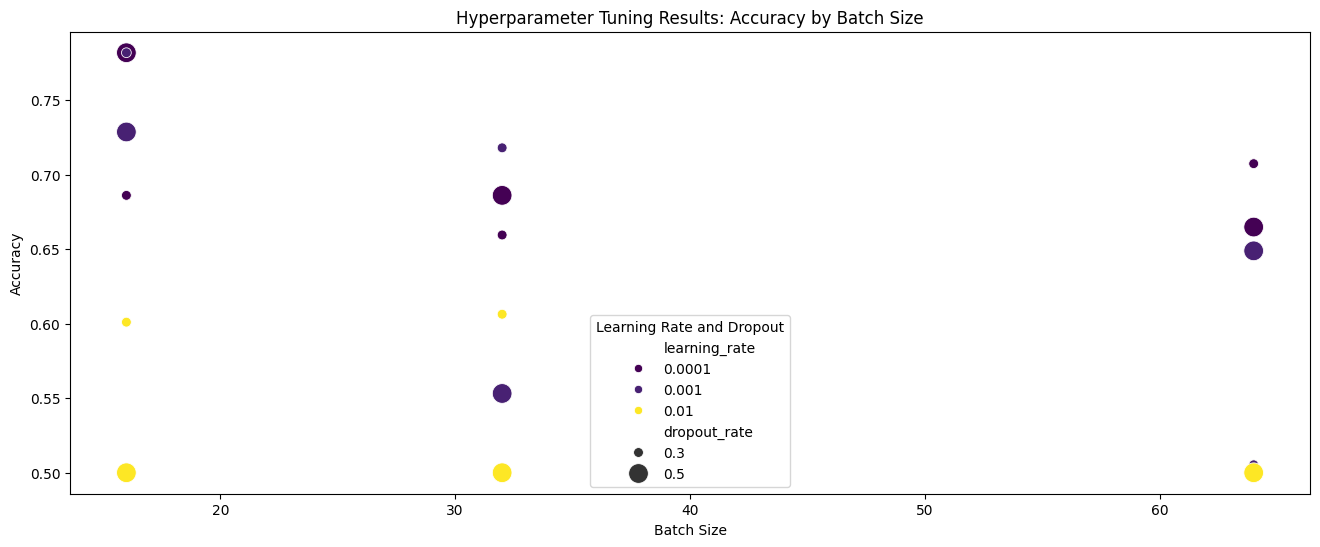

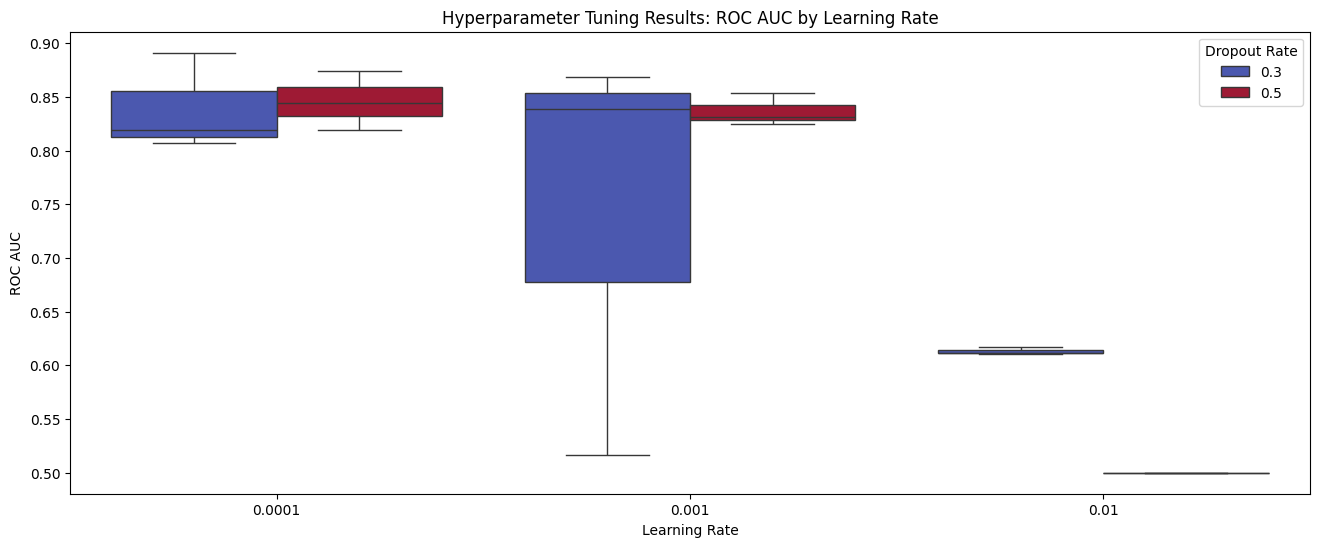

In [41]:
# Hyperparameter Tuning Results
plt.figure(figsize=(16, 6))
sns.scatterplot(data=tuning_results_df, x='batch_size', y='accuracy', hue='learning_rate', size='dropout_rate', sizes=(50, 200), palette='viridis')
plt.title('Hyperparameter Tuning Results: Accuracy by Batch Size')
plt.xlabel('Batch Size')
plt.ylabel('Accuracy')
plt.legend(title='Learning Rate and Dropout')
plt.show()

plt.figure(figsize=(16, 6))
sns.boxplot(data=tuning_results_df, x='learning_rate', y='roc_auc', hue='dropout_rate', palette='coolwarm')
plt.title('Hyperparameter Tuning Results: ROC AUC by Learning Rate')
plt.xlabel('Learning Rate')
plt.ylabel('ROC AUC')
plt.legend(title='Dropout Rate')
plt.show()

In [50]:
cm = [[70,17],[24,77]]

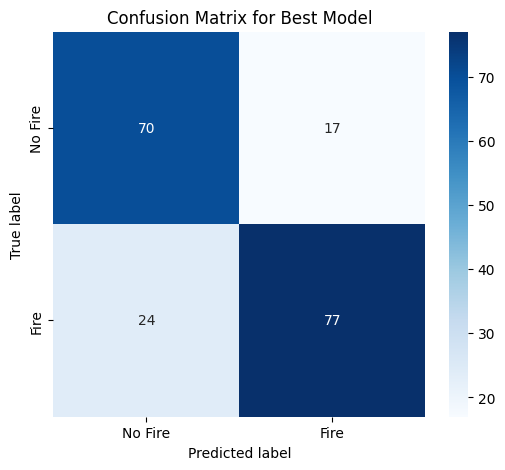

In [51]:
# Confusion Matrix for Best Model
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Fire', 'Fire'], yticklabels=['No Fire', 'Fire'])
plt.title('Confusion Matrix for Best Model')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()